### Lanzcos algorithm

For eigenvalue problem of symmetric matrices. 

maintian a $v - \alpha_j q_j - \beta_j q_{j-1}$


In [ ]:
import numpy as np

def lanczos(A, b, k):
    n = len(b)
    Q = np.zeros((n, k+1))
    alpha = np.zeros(k)
    beta = np.zeros(k+1)

    Q[:, 0] = b / np.linalg.norm(b)

    v = np.zeros(n)

    for j in range(k):
        v = A @ Q[:, j]
        alpha[j] = np.dot(Q[:, j], v)
        v = v - alpha[j] * Q[:, j] - (beta[j] * Q[:, j-1] if j > 0 else 0)
        beta[j+1] = np.linalg.norm(v)

        if beta[j+1] == 0:
            break
        Q[:, j+1] = v / beta[j+1]

    return Q, alpha, beta

# test
A = np.array([[4., 1.], [1., 3.]])
b = np.array([1., 2.])

Q, alpha, beta = lanczos(A, b, k=2)
print("alpha:", alpha)
print("beta:", beta)


Let \( A \) be the \( 1000 \times 1000 \) symmetric matrix whose entries are all zero except for \( a_{ii} = \sqrt{i} \) on the diagonal, \( a_{ij} = 1 \) on the sub- and superdiagonals, and \( a_{ij} = 1 \) on the 100th sub- and superdiagonals, i.e., for \( |i - j| = 100 \). Determine the smallest eigenvalue of \( A \) to six digits of accuracy by the Lanczos iteration.



In [1]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

# 1. Define the parameters
N = 1000

# 2. Construct the diagonals
# Note: Mathematical index i=1..1000 corresponds to Python index 0..999.
# The problem states a_ii = sqrt(i), so we generate sqrt(1) to sqrt(1000).
main_diag = np.sqrt(np.arange(1, N + 1))
off_diag_1 = np.ones(N - 1)
off_diag_100 = np.ones(N - 100)

# 3. Create the sparse matrix
# Offsets: 0 (main), 1 (super), -1 (sub), 100 (super-100), -100 (sub-100)
diagonals = [main_diag, off_diag_1, off_diag_1, off_diag_100, off_diag_100]
offsets = [0, 1, -1, 100, -100]
A = diags(diagonals, offsets, shape=(N, N))

# 4. Compute the smallest eigenvalue using Lanczos iteration
# 'SA' stands for Smallest Algebraic (taking into account sign).
# tol=1e-9 ensures high precision (better than 6 digits).
eigenvalues, eigenvectors = eigsh(A, k=1, which='SA', tol=1e-9)

# 5. Print the result
print(f"The smallest eigenvalue is approximately: {eigenvalues[0]:.6f}")

The smallest eigenvalue is approximately: -0.300963


Ritz approximation:


eigenvalues of $T_{l}$

Cauchy interlace theorem shows that for ay i: $\lambda_i(T_k)$ increases monotonically with $k$: $\lambda_i(T_{k+1}) \ge \lambda_i(T_{k}) \ge \lambda_{i+1}(T_{k+1}) \ge \lambda_{i+1}(T_{k})$

Computing Part (a)...
Computing Part (b)...
Computing Part (c)...


/var/folders/wl/tst5j8ss72n81nsz8b26y1f40000gn/T/ipykernel_12181/1234075973.py:62: RuntimeWarning: divide by zero encountered in matmul
  v = A @ Q[:, n]
/var/folders/wl/tst5j8ss72n81nsz8b26y1f40000gn/T/ipykernel_12181/1234075973.py:62: RuntimeWarning: overflow encountered in matmul
  v = A @ Q[:, n]
/var/folders/wl/tst5j8ss72n81nsz8b26y1f40000gn/T/ipykernel_12181/1234075973.py:62: RuntimeWarning: invalid value encountered in matmul
  v = A @ Q[:, n]


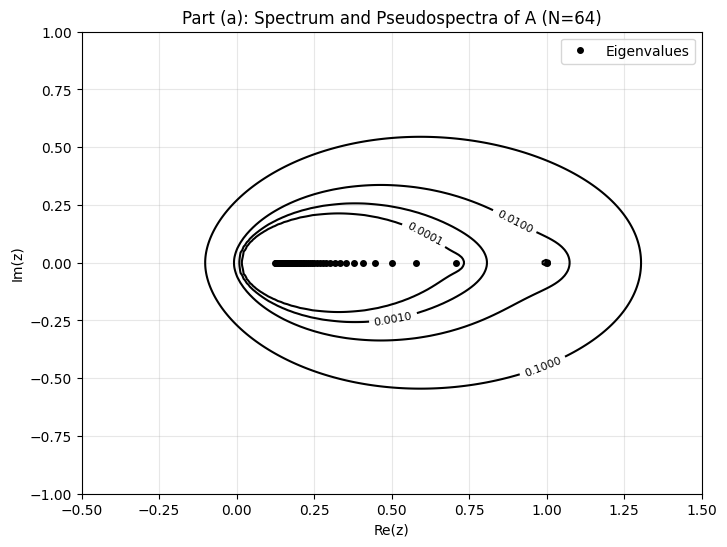

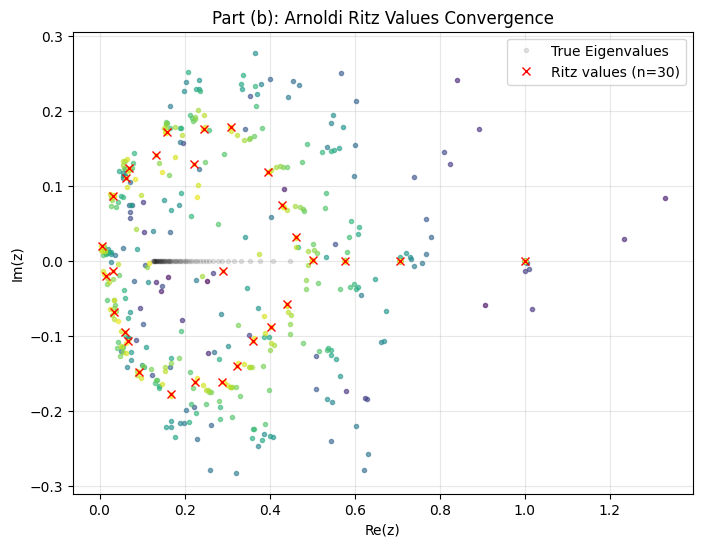

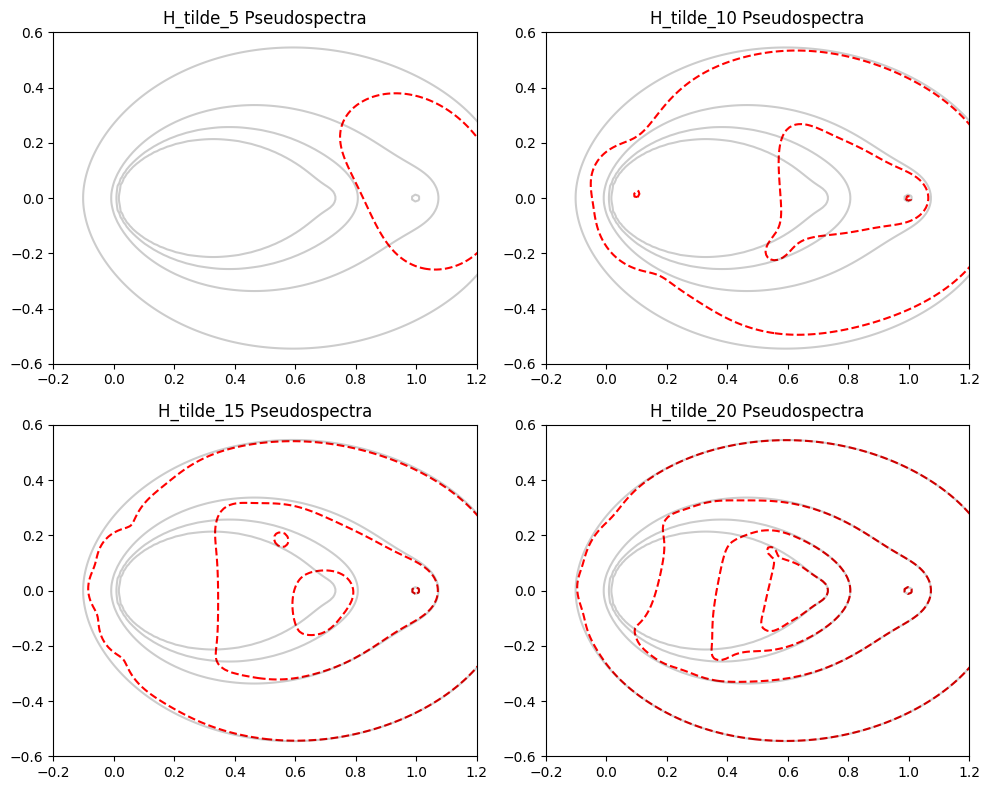

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svdvals, hessenberg, eigvals

# --- Setup ---
N = 64
k_vals = np.arange(1, N + 1)
diag_entries = 1.0 / np.sqrt(k_vals)

# Construct Matrix A (Upper Bidiagonal)
A = np.diag(diag_entries) + np.diag(diag_entries[:-1], k=1)

# Pseudospectra parameters
epsilons = sorted([1e-1, 1e-2, 1e-3, 1e-4])
# Grid for plotting
x = np.linspace(-0.5, 1.5, 200)
y = np.linspace(-1.0, 1.0, 200)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

def compute_resolvent_norm_grid(Matrix, grid_z):
    """Computes singular value of (zI - M) for a grid of z."""
    s_min = np.zeros_like(grid_z, dtype=float)
    I = np.eye(Matrix.shape[0])
    rows, cols = grid_z.shape
    for i in range(rows):
        for j in range(cols):
            z = grid_z[i, j]
            # sigma_min(zI - A)
            s_min[i, j] = np.min(svdvals(z * I - Matrix))
    return s_min

# --- Part (a): Spectrum and Pseudospectra of A ---
print("Computing Part (a)...")
sigmin_A = compute_resolvent_norm_grid(A, Z)
eigenvalues_A = np.linalg.eigvals(A)

fig_a, ax_a = plt.subplots(figsize=(8, 6))
ax_a.plot(eigenvalues_A.real, eigenvalues_A.imag, 'k.', markersize=8, label='Eigenvalues')
cs = ax_a.contour(X, Y, sigmin_A, levels=epsilons, colors='k')
ax_a.clabel(cs, inline=True, fontsize=8)
ax_a.set_title(f"Part (a): Spectrum and Pseudospectra of A (N={N})")
ax_a.set_xlabel("Re(z)")
ax_a.set_ylabel("Im(z)")
ax_a.grid(True, alpha=0.3)
ax_a.legend()

# --- Part (b): Arnoldi Iteration ---
print("Computing Part (b)...")
n_steps = 30
np.random.seed(0) 
b = np.random.randn(N) + 1j * np.random.randn(N)
b = b / np.linalg.norm(b)

Q = np.zeros((N, n_steps + 1), dtype=complex)
H = np.zeros((n_steps + 1, n_steps), dtype=complex)
Q[:, 0] = b

ritz_history = []

for n in range(n_steps):
    v = A @ Q[:, n]
    # Modified Gram-Schmidt
    for j in range(n + 1):
        H[j, n] = np.vdot(Q[:, j], v)
        v = v - H[j, n] * Q[:, j]
    
    H[n + 1, n] = np.linalg.norm(v)
    if H[n + 1, n] > 1e-14:
        Q[:, n + 1] = v / H[n + 1, n]
    
    # Compute Ritz values for step n+1
    H_n = H[:n+1, :n+1]
    ritz_vals = np.linalg.eigvals(H_n)
    ritz_history.append(ritz_vals)

fig_b, ax_b = plt.subplots(figsize=(8, 6))
# Plot actual eigenvalues in background
ax_b.plot(eigenvalues_A.real, eigenvalues_A.imag, 'k.', alpha=0.1, label='True Eigenvalues')
# Plot Ritz values history
colors = plt.cm.viridis(np.linspace(0, 1, n_steps))
for i, ritz in enumerate(ritz_history):
    ax_b.plot(ritz.real, ritz.imag, 'o', color=colors[i], markersize=3, alpha=0.6)

# Highlight final step
ax_b.plot(ritz_history[-1].real, ritz_history[-1].imag, 'rx', markersize=6, label=f'Ritz values (n={n_steps})')
ax_b.set_title("Part (b): Arnoldi Ritz Values Convergence")
ax_b.set_xlabel("Re(z)")
ax_b.set_ylabel("Im(z)")
ax_b.grid(True, alpha=0.3)
ax_b.legend()

# --- Part (c): Pseudospectra of Rectangular Hessenberg ---
print("Computing Part (c)...")
ns_to_plot = [5, 10, 15, 20]
fig_c, axes_c = plt.subplots(2, 2, figsize=(10, 8))
axes_c = axes_c.flatten()

# We need a special function for rectangular pseudospectra (sigma_min of (zI_rect - H_tilde))
def compute_rect_resolvent(H_tilde, grid_z):
    rows_H, cols_H = H_tilde.shape
    s_min = np.zeros_like(grid_z, dtype=float)
    # Rectangular Identity (rows_H x cols_H)
    I_rect = np.eye(rows_H, cols_H)
    
    r_grid, c_grid = grid_z.shape
    for i in range(r_grid):
        for j in range(c_grid):
            z = grid_z[i, j]
            # sigma_min(z * I_rect - H_tilde)
            # This is equivalent to finding smallest singular value of the matrix
            val = np.linalg.svd(z * I_rect - H_tilde, compute_uv=False)[-1]
            s_min[i, j] = val
    return s_min

for idx, n in enumerate(ns_to_plot):
    # H_tilde is the (n+1) x n part of H
    H_tilde = H[:n+1, :n]
    
    # Compute pseudospectra for this H_tilde
    sigmin_H = compute_rect_resolvent(H_tilde, Z)
    
    # Plot
    ax = axes_c[idx]
    ax.contour(X, Y, sigmin_H, levels=epsilons, colors='r', linestyles='--')
    # Overlay true pseudospectra for comparison (faint)
    ax.contour(X, Y, sigmin_A, levels=epsilons, colors='k', alpha=0.2)
    ax.set_title(f"H_tilde_{n} Pseudospectra")
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.6, 0.6)

plt.tight_layout()
plt.show()